In [3]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from matplotlib.pyplot import figure
from matplotlib import patches

import nilearn
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
import pandas as pd

from os.path import join as opj
from nibabel.testing import data_path
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12
#tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii' # normalization template

from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
#from bids.layout import BIDSLayout
from nipype.algorithms.misc import Gunzip

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import nibabel as nib
from nilearn import datasets

from dipy.io.image import load_nifti

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


220519-00:29:10,345 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.8.0


## Making an individual model for every subject

In [2]:
def Classificationbuilder (data_folder,subject_code,fildd,n_components,ANNlayers,model_code):
     for i in  subject_code:
        print("Subject analyzed: {:.3f}".format(i))
        subject_folder='/sub-xp'
        String_contrinuation1='/func/sub-xp'
        String_contrinuation2=fildd
        subject_codee=str(i)
        
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
        fmri_rest=[]
        fmri_rest_todos=[]
        
        if fildd=='_task-motorloc_bold.nii.gz':
            r1=range(1,161,20)
            r2=range(11,171,20)
        
        else: 
            r1=range(1,201,20)
            r2=range(11,211,20)
        
        for rest in r1:
            fmri_rest=fmri_img[:,:,:,rest:rest+10]
            if rest==1:
                fmri_rest_todos=fmri_rest
            else:
                fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
        fmri_task=[]
        fmri_task_todos=[]

        for task in r2:
            fmri_task=fmri_img[:,:,:,task:task+10]
            if task==11:
                fmri_task_todos=fmri_task
            else:
                fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
        
        
        if fildd=='_task-motorloc_bold.nii.gz':
            X=np.zeros((160,11236))
            Y=np.zeros((160,1))
            for i in range(0,80,1):
                a=fmri_rest_todos[:,:,15,i]
                X[i,:]=a.flatten()
                Y[i,0]=0
            for i in range(0,80,1):
                a=fmri_task_todos[:,:,15,i]
                X[i+80,:]=a.flatten()
                Y[i+80,0]=1
            
        else:     
            X=np.zeros((200,11236))
            Y=np.zeros((200,1))
            for i in range(0,100,1):
                a=fmri_rest_todos[:,:,15,i]
                X[i,:]=a.flatten()
                Y[i,0]=0
            for i in range(0,100,1):
                a=fmri_task_todos[:,:,15,i]
                X[i+100,:]=a.flatten()
                Y[i+100,0]=1
            
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.35)
        

        pca = PCA(n_components=n_components, svd_solver='randomized',
                  whiten=True).fit(X_train)
        
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        y_train = column_or_1d(np.ravel(y_train), warn=True)
        y_test = column_or_1d(np.ravel(y_test), warn=True)

        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
        svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
        svm = svm.fit(X_train_pca, y_train)
        
        target_names=np.array(['Rest', 'Task'])
        n_classes=2
        
        y_pred_svm = svm.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_svm)*100
        print("SVC accuracy: {:.3f}%".format(numerito))
        
        lda = LinearDiscriminantAnalysis()
        lda = lda.fit(X_train_pca, y_train)
        y_pred_lda = lda.predict(X_test_pca)

        numerito=accuracy_score(y_test,y_pred_lda)*100
        print("LDA accuracy: {:.3f}%".format(numerito))
        
        dt = DecisionTreeClassifier()
        dt = dt.fit(X_train_pca, y_train)
        y_pred_dt = dt.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_dt)*100
        print("DT accuracy: {:.3f}%".format(numerito))
        
        ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(ANNlayers,), random_state=1)
        ann.fit(X_train_pca, y_train)
        y_pred_ann = ann.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_ann)*100
        print("ANN accuracy: {:.3f}%".format(numerito))
        print("\n")

        
            
        

In [11]:
data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
#data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'
fild_to_study='_task-eegfmriNF_bold.nii.gz'
subject_code=[101,102,103,104,105,106,107,108,109,110]

Classificationbuilder (data_folder,subject_code,fild_to_study,100,150,101)

Subject analyzed: 101.000
SVC accuracy: 48.571%
LDA accuracy: 81.429%
DT accuracy: 71.429%
ANN accuracy: 81.429%


Subject analyzed: 102.000
SVC accuracy: 71.429%
LDA accuracy: 64.286%
DT accuracy: 55.714%
ANN accuracy: 64.286%


Subject analyzed: 103.000
SVC accuracy: 71.429%
LDA accuracy: 71.429%
DT accuracy: 61.429%
ANN accuracy: 71.429%


Subject analyzed: 104.000
SVC accuracy: 67.143%
LDA accuracy: 67.143%
DT accuracy: 64.286%
ANN accuracy: 70.000%


Subject analyzed: 105.000
SVC accuracy: 71.429%
LDA accuracy: 71.429%
DT accuracy: 62.857%
ANN accuracy: 70.000%


Subject analyzed: 106.000
SVC accuracy: 58.571%
LDA accuracy: 62.857%
DT accuracy: 38.571%
ANN accuracy: 62.857%


Subject analyzed: 107.000
SVC accuracy: 58.571%
LDA accuracy: 81.429%
DT accuracy: 60.000%
ANN accuracy: 81.429%


Subject analyzed: 108.000
SVC accuracy: 70.000%
LDA accuracy: 71.429%
DT accuracy: 58.571%
ANN accuracy: 71.429%


Subject analyzed: 109.000
SVC accuracy: 71.429%
LDA accuracy: 77.143%
DT accurac

## Applying the model from one subject to all of them

### With fitting

In [5]:
def Aplication_of_clasiffier (data_folder, subject_code, fildd, studiedsubject, n_components, method):
    print("Subject analyzed: {:.3f}".format(studiedsubject))
    subject_folder='/sub-xp'
    String_contrinuation1='/func/sub-xp'
    String_contrinuation2=fildd
    subject_codee=str(studiedsubject)
        
    subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
    fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
    fmri_rest=[]
    fmri_rest_todos=[]
        
    if fildd=='_task-eegfmriNF_bold.nii.gz':
        r1=range(1,201,20)
        r2=range(11,211,20)
        
    for rest in r1:
        fmri_rest=fmri_img[:,:,:,rest:rest+10]
        if rest==1:
            fmri_rest_todos=fmri_rest
        else:
            fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
    fmri_task=[]
    fmri_task_todos=[]

    for task in r2:
        fmri_task=fmri_img[:,:,:,task:task+10]
        if task==11:
            fmri_task_todos=fmri_task
        else:
            fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
        
    X=np.zeros((200,11236))
    Y=np.zeros((200,1))
    for i in range(0,100,1):
        a=fmri_rest_todos[:,:,15,i]
        X[i,:]=a.flatten()
        Y[i,0]=0
    for i in range(0,100,1):
        a=fmri_task_todos[:,:,15,i]
        X[i+100,:]=a.flatten()
        Y[i+100,0]=1
            
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.35)
        
        
    pca = PCA(n_components=n_components, svd_solver='randomized',
                whiten=True).fit(X_train)
        
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
        
    y_train = column_or_1d(np.ravel(y_train), warn=True)
    y_test = column_or_1d(np.ravel(y_test), warn=True)

    n_classes=2
    
    if method == 'svm':
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
        subjectmodel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
        subjectmodel = subjectmodel.fit(X_train_pca, y_train)
    
        
        target_names=np.array(['Rest', 'Task'])
        
    
        y_pred_svm = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_svm)*100
        print("SVC accuracy: {:.3f}".format(numerito))
        
    elif method == 'lda':
        
        subjectmodel = LinearDiscriminantAnalysis()
        subjectmodel = subjectmodel.fit(X_train_pca, y_train)
        y_pred_lda = subjectmodel.predict(X_test_pca)

        numerito=accuracy_score(y_test,y_pred_lda)*100
        print("LDA accuracy: {:.3f}".format(numerito))
        
    elif method == 'dt':
        
        subjectmodel = DecisionTreeClassifier()
        subjectmodel = subjectmodel.fit(X_train_pca, y_train)
        y_pred_dt = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_dt)*100
        print("DT accuracy: {:.3f}".format(numerito))
        
    elif method == 'ann':
        
        subjectmodel = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(150,), random_state=1)
        subjectmodel.fit(X_train_pca, y_train)
        y_pred_ann = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_ann)*100
        print("ANN accuracy: {:.3f}".format(numerito))
    
    for i in  subject_code:
        print("\n")
        print("Subject analyzed: {:.3f}".format(i))
        subject_folder='/sub-xp'
        String_contrinuation1='/func/sub-xp'
        String_contrinuation2=fildd
        subject_codee=str(i)
        
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
        fmri_rest=[]
        fmri_rest_todos=[]
        
        if fildd=='_task-eegfmriNF_bold.nii.gz':
            r1=range(1,201,20)
            r2=range(11,211,20)
        
        for rest in r1:
            fmri_rest=fmri_img[:,:,:,rest:rest+10]
            if rest==1:
                fmri_rest_todos=fmri_rest
            else:
                fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
        fmri_task=[]
        fmri_task_todos=[]

        for task in r2:
            fmri_task=fmri_img[:,:,:,task:task+10]
            if task==11:
                fmri_task_todos=fmri_task
            else:
                fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
                
        X=np.zeros((200,11236))
        Y=np.zeros((200,1))
        for i in range(0,100,1):
            a=fmri_rest_todos[:,:,15,i]
            X[i,:]=a.flatten()
            Y[i,0]=0
        for i in range(0,100,1):
            a=fmri_task_todos[:,:,15,i]
            X[i+100,:]=a.flatten()
            Y[i+100,0]=1
            
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.35)
        
        pca = PCA(n_components=n_components, svd_solver='randomized',
                  whiten=True).fit(X_train)
        
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        y_train = column_or_1d(np.ravel(y_train), warn=True)
        y_test = column_or_1d(np.ravel(y_test), warn=True)
        
        subjectmodel.fit(X_train_pca, y_train)
        y_pred = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred)*100
        print("Model accuracy: {:.3f}%".format(numerito))
        
        

In [12]:
data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
#data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'
fild_to_study='_task-eegfmriNF_bold.nii.gz'
subject_code=[101,102,103,104,105,106,107,108,109,110]

Aplication_of_clasiffier (data_folder, subject_code, fild_to_study, 101, 100, 'ann')

Subject analyzed: 101.000
ANN accuracy: 74.286


Subject analyzed: 101.000
Model accuracy: 84.286%


Subject analyzed: 102.000
Model accuracy: 72.857%


Subject analyzed: 103.000
Model accuracy: 68.571%


Subject analyzed: 104.000
Model accuracy: 75.714%


Subject analyzed: 105.000
Model accuracy: 77.143%


Subject analyzed: 106.000
Model accuracy: 70.000%


Subject analyzed: 107.000
Model accuracy: 74.286%


Subject analyzed: 108.000
Model accuracy: 72.857%


Subject analyzed: 109.000
Model accuracy: 67.143%


Subject analyzed: 110.000
Model accuracy: 75.714%


### without fitting

In [7]:
def Aplication_of_clasiffier2 (data_folder, subject_code, fildd, studiedsubject, n_components, method):
    print("Subject analyzed: {:.3f}".format(studiedsubject))
    subject_folder='/sub-xp'
    String_contrinuation1='/func/sub-xp'
    String_contrinuation2=fildd
    subject_codee=str(studiedsubject)
        
    subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
    fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
    fmri_rest=[]
    fmri_rest_todos=[]
        
    if fildd=='_task-eegfmriNF_bold.nii.gz':
        r1=range(1,201,20)
        r2=range(11,211,20)
        
    for rest in r1:
        fmri_rest=fmri_img[:,:,:,rest:rest+10]
        if rest==1:
            fmri_rest_todos=fmri_rest
        else:
            fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
    fmri_task=[]
    fmri_task_todos=[]

    for task in r2:
        fmri_task=fmri_img[:,:,:,task:task+10]
        if task==11:
            fmri_task_todos=fmri_task
        else:
            fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
        
    X=np.zeros((200,11236))
    Y=np.zeros((200,1))
    for i in range(0,100,1):
        a=fmri_rest_todos[:,:,15,i]
        X[i,:]=a.flatten()
        Y[i,0]=0
    for i in range(0,100,1):
        a=fmri_task_todos[:,:,15,i]
        X[i+100,:]=a.flatten()
        Y[i+100,0]=1
            
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.35)
        
        
    pca = PCA(n_components=n_components, svd_solver='randomized',
                whiten=True).fit(X_train)
        
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
        
    y_train = column_or_1d(np.ravel(y_train), warn=True)
    y_test = column_or_1d(np.ravel(y_test), warn=True)

    n_classes=2
    
    if method == 'svm':
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
        subjectmodel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
        subjectmodel = subjectmodel.fit(X_train_pca, y_train)
    
        
        target_names=np.array(['Rest', 'Task'])
        
    
        y_pred_svm = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_svm)*100
        print("SVC accuracy: {:.3f}".format(numerito))
        
    elif method == 'lda':
        
        subjectmodel = LinearDiscriminantAnalysis()
        subjectmodel = subjectmodel.fit(X_train_pca, y_train)
        y_pred_lda = subjectmodel.predict(X_test_pca)

        numerito=accuracy_score(y_test,y_pred_lda)*100
        print("LDA accuracy: {:.3f}".format(numerito))
        
    elif method == 'dt':
        
        subjectmodel = DecisionTreeClassifier()
        subjectmodel = subjectmodel.fit(X_train_pca, y_train)
        y_pred_dt = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_dt)*100
        print("DT accuracy: {:.3f}".format(numerito))
        
    elif method == 'ann':
        
        subjectmodel = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(150,), random_state=1)
        subjectmodel.fit(X_train_pca, y_train)
        y_pred_ann = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_ann)*100
        print("ANN accuracy: {:.3f}".format(numerito))
    
    for i in  subject_code:
        print("\n")
        print("Subject analyzed: {:.3f}".format(i))
        subject_folder='/sub-xp'
        String_contrinuation1='/func/sub-xp'
        String_contrinuation2=fildd
        subject_codee=str(i)
        
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
        fmri_rest=[]
        fmri_rest_todos=[]
        
        if fildd=='_task-eegfmriNF_bold.nii.gz':
            r1=range(1,201,20)
            r2=range(11,211,20)
        
        for rest in r1:
            fmri_rest=fmri_img[:,:,:,rest:rest+10]
            if rest==1:
                fmri_rest_todos=fmri_rest
            else:
                fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
        fmri_task=[]
        fmri_task_todos=[]

        for task in r2:
            fmri_task=fmri_img[:,:,:,task:task+10]
            if task==11:
                fmri_task_todos=fmri_task
            else:
                fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
                
        X=np.zeros((200,11236))
        Y=np.zeros((200,1))
        for i in range(0,100,1):
            a=fmri_rest_todos[:,:,15,i]
            X[i,:]=a.flatten()
            Y[i,0]=0
        for i in range(0,100,1):
            a=fmri_task_todos[:,:,15,i]
            X[i+100,:]=a.flatten()
            Y[i+100,0]=1
            

        
        pca = PCA(n_components=n_components, svd_solver='randomized',
                  whiten=True).fit(X)
        
        X_test_pca = pca.transform(X)
        
        y_test = column_or_1d(np.ravel(Y), warn=True)
        
        y_pred = subjectmodel.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred)*100
        print("Model accuracy: {:.3f}%".format(numerito))
        

In [10]:
data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
#data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'
fild_to_study='_task-eegfmriNF_bold.nii.gz'
subject_code=[101,102,103,104,105,106,107,108,109,110]

Aplication_of_clasiffier2 (data_folder, subject_code, fild_to_study, 101, 100, 'ann')

Subject analyzed: 101.000
ANN accuracy: 91.429


Subject analyzed: 101.000
Model accuracy: 45.000%


Subject analyzed: 102.000
Model accuracy: 50.500%


Subject analyzed: 103.000
Model accuracy: 43.500%


Subject analyzed: 104.000
Model accuracy: 57.500%


Subject analyzed: 105.000
Model accuracy: 55.000%


Subject analyzed: 106.000
Model accuracy: 53.000%


Subject analyzed: 107.000
Model accuracy: 51.000%


Subject analyzed: 108.000
Model accuracy: 48.000%


Subject analyzed: 109.000
Model accuracy: 56.000%


Subject analyzed: 110.000
Model accuracy: 55.500%


## General model for all subjects combined (2000 slices)

In [55]:
def Subjects_classification_allslides (data_folder,subject_code,fildd,n_components,ANNlayers):
    
    fmri_rest_todos=[]
    fmri_task_todos=[]
    
    for i in  subject_code:
        if i == subject_code[round(len(subject_code)/2)]:
            print("Half subjects averaged, no time for a coffe")
        subject_folder='/sub-xp'
        String_contrinuation1='/func/sub-xp'
        String_contrinuation2=fildd
        subject_codee=str(i)
        
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
        
        fmri_rest=[]
        fmri_task=[]
        
        a=range(1,201,20)

        for rest in a:
            fmri_rest=fmri_img[:,:,:,rest:rest+10]
            if rest==1 and i==subject_code[0]:
                fmri_rest_todos=fmri_rest
            else:
                fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
      
        for task in range (11,211,20):
            fmri_task=fmri_img[:,:,:,task:task+10]
            if task==11 and i==subject_code[0]:
                fmri_task_todos=fmri_task
            else:
                fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
                
    print("\n")
    print("Starting the model generation, it will not take too much, I hope...")
    X=np.zeros((2000,11236))
    Y=np.zeros((2000,1))
    
    
    for i in range(0,1000,1):
        a=fmri_rest_todos[:,:,15,i]
        X[i,:]=a.flatten()
        Y[i,0]=0
    for i in range(0,1000,1):
        a=fmri_task_todos[:,:,15,i]
        X[i+1000,:]=a.flatten()
        Y[i+1000,0]=1
            
    X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.35)
        

    pca = PCA(n_components=n_components, svd_solver='randomized',
                  whiten=True).fit(X_train)
        
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
        
    y_train = column_or_1d(np.ravel(y_train), warn=True)
    y_test = column_or_1d(np.ravel(y_test), warn=True)

    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    svm = svm.fit(X_train_pca, y_train)
        
    target_names=np.array(['Rest', 'Task'])
    n_classes=2
    print("\n")
    print("Classification over the 1000 rest and 1000 task slices:")
        
    y_pred_svm = svm.predict(X_test_pca)
    numerito=accuracy_score(y_test,y_pred_svm)*100
    print("SVC accuracy: {:.3f}%".format(numerito))
        
    lda = LinearDiscriminantAnalysis()
    lda = lda.fit(X_train_pca, y_train)
    y_pred_lda = lda.predict(X_test_pca)

    numerito=accuracy_score(y_test,y_pred_lda)*100
    print("LDA accuracy: {:.3f}%".format(numerito))
        
    dt = DecisionTreeClassifier()
    dt = dt.fit(X_train_pca, y_train)
    y_pred_dt = dt.predict(X_test_pca)
    numerito=accuracy_score(y_test,y_pred_dt)*100
    print("DT accuracy: {:.3f}%".format(numerito))
        
    ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(ANNlayers,), random_state=1)
    ann.fit(X_train_pca, y_train)
    y_pred_ann = ann.predict(X_test_pca)
    numerito=accuracy_score(y_test,y_pred_ann)*100
    print("ANN accuracy: {:.3f}%".format(numerito))
    print("\n")
        
    
     

In [56]:
#data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'
fild_to_study='_task-eegfmriNF_bold.nii.gz'
subject_code=[101,102,103,104,105,106,107,108,109,110]

Subjects_classification_allslides(data_folder, subject_code, fild_to_study,200,15)

Half subjects averaged, no time for a coffe


Starting the model generation, it will not take too much, I hope...


Classification over the 1000 rest and 1000 task slices:
SVC accuracy: 62.571%
LDA accuracy: 65.429%
DT accuracy: 59.286%
ANN accuracy: 65.286%




## Subject mean epoch classification.

In [54]:
def Subjects_classification_epochs (data_folder,subject_code,fildd,n_components,ANNlayers):
    
    fmri_rest_todos=np.zeros((106,106,32,100))
    fmri_task_todos=np.zeros((106,106,32,100))
    count=0
    count2=0
    for i in  range(len(subject_code)):
        if i == round(len(subject_code)/2):
            print("Half subjects averaged, no time for a coffe")
        subject_folder='/sub-xp'
        String_contrinuation1='/func/sub-xp'
        String_contrinuation2=fildd
        subject_codee=str(subject_code[i])
        
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
        
        fmri_rest=[]
        fmri_task=[]
        
        a=range(1,201,20)

        for rest in a:
            fmri_rest=fmri_img[:,:,:,rest+1:rest+9]
            fmri_rest_mean=np.mean(fmri_rest, axis=3)
            fmri_rest_todos[:,:,:,count]=fmri_rest_mean
            count+=1


      
        for task in range (11,211,20):
            fmri_task=fmri_img[:,:,:,task+1:task+9]
            fmri_task_mean=np.mean(fmri_task, axis=3)
            fmri_task_todos[:,:,:,count2]=fmri_rest_mean
            count2+=1

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(fmri_rest_todos[:,:,15,99])
    axs[0].set_title('fmri_rest')
    axs[1].imshow(fmri_task_todos[:,:,15,99])
    axs[1].set_title('fmri_task')
    print("\n")
    print("Meanwhile the classifier models are created you can point the differences between those images :)")
    print("\n")
    X=np.zeros((200,11236))
    Y=np.zeros((200,1))
    
    
    for i in range(0,100,1):
        a=fmri_rest_todos[:,:,15,i]
        X[i,:]=a.flatten()
        Y[i,0]=0
    for i in range(0,100,1):
        a=fmri_task_todos[:,:,15,i]
        X[i+100,:]=a.flatten()
        Y[i+100,0]=1
            
    X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.35)
        

    pca = PCA(n_components=n_components, svd_solver='randomized',
                  whiten=True).fit(X_train)
        
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
        
    y_train = column_or_1d(np.ravel(y_train), warn=True)
    y_test = column_or_1d(np.ravel(y_test), warn=True)

    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    svm = svm.fit(X_train_pca, y_train)
        
    target_names=np.array(['Rest', 'Task'])
    n_classes=2
        
    y_pred_svm = svm.predict(X_test_pca)
    numerito=accuracy_score(y_test,y_pred_svm)*100
    print("SVC accuracy: {:.3f}%".format(numerito))
        
    lda = LinearDiscriminantAnalysis()
    lda = lda.fit(X_train_pca, y_train)
    y_pred_lda = lda.predict(X_test_pca)

    numerito=accuracy_score(y_test,y_pred_lda)*100
    print("LDA accuracy: {:.3f}%".format(numerito))
        
    dt = DecisionTreeClassifier()
    dt = dt.fit(X_train_pca, y_train)
    y_pred_dt = dt.predict(X_test_pca)
    numerito=accuracy_score(y_test,y_pred_dt)*100
    print("DT accuracy: {:.3f}%".format(numerito))
        
    ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(ANNlayers,))
    ann.fit(X_train_pca, y_train)
    y_pred_ann = ann.predict(X_test_pca)
    numerito=accuracy_score(y_test,y_pred_ann)*100
    print("ANN accuracy: {:.3f}%".format(numerito))
    print("\n")
    
        

Half subjects averaged, no time for a coffe


Meanwhile the classifier models are created you can point the differences between those images :)


SVC accuracy: 95.714%
LDA accuracy: 78.571%
DT accuracy: 91.429%
ANN accuracy: 85.714%




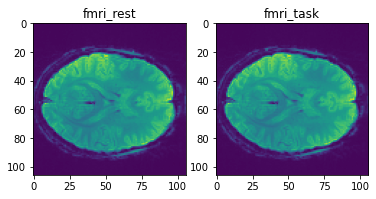

In [46]:
#data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'
fild_to_study='_task-eegfmriNF_bold.nii.gz'
subject_code=[101,102,103,104,105,106,107,108,109,110]

Subjects_classification_epochs(data_folder, subject_code, fild_to_study,110,15)